# Allen Majewski 20200107


### TOC

#### Problem Statement

#### Preamble: My Approach

#### Sections:

    1. Data Construction
        
        - Define objectives to predict
            * continuous variable: tip_fraction
            * binary variable: tip_over_twenty_percent
        
        - Derive plausible feature data e.g. weekday (M-F,Sa,Su), is_holiday, etc.
        
        - Distinguish and separate continuous and categorical input data
        
    2. Data Investigation & Preliminary Feature Selection
    
    
        - Examine importance of variables.  Conclusions:
            * Tip distribution is N-modal with N>=4. See histogram in figs/.
            * Many continuous variables, particularly fare-related, are highly correlated and can be dropped
        
        - Noticable trends by-eye
            * Tips tend higher for borough 2 (Manhattan)
            * Tips fall off as number of passengers increases - bystander effect? (not my job to tip!)
            * Thanksgiving tips and Independence Day tips can be higher than normal (not christmas!).  
               (The "None-holiday" still has the most large tips).
            * The biggest tips occur on Sunday and Friday
            * Vendor 1 has some higher tips (uber or lyft, data doesnt say).
            
    3. Encoding and Model Selection, Results
            
         - Regression Models
                * LinearRegression - terrible results
                * LogistricRegression - 96% accuracy ... this should be verified
                * RidgeCV, LassoCV - Lasso Regression threw out the trip distance and the fare amount as inconsequential.  All Regressions had poor accuracy.
         - Classification Models
                * GaussianNB
                * 
                
    4. Considerations for further work
         
         - would like to consider inbound/outbound journey as a variable
         
         - would like to consider rush hour, traffic conditions. Using hour 
            of the day a possibility, in combination with another dataset on traffic/travel times
         
         - obviously, more careful model selection and parameter tuning.  better investigation into meaningful 
            features v.s. correlated/random variables with no correlation.


-------




## Problem Statement

##### Data
	1. NYC taxi trip history data from 2015/01 – 2015/12
	2. Daily weather data from 2015/01 – 2015/12
	3. Public holiday data for the year of 2015

##### Problem
Build an ML model to predict whether each trip has over 20% tip rate or not.

##### Expected outputs

	1. Please submit the code you developed to build predictive model(s) as Jupyter notebook(s) on Python3 kernel.
	2. Please summarize the key conclusion of your analysis. This report should include the following:
		a. The most significant features that affect each trip’s tip percentage.
		b. The performance of your predictive model(s), and suggest what additional dataset you’d like to include to improve the performance of your models.

##### Note
	1.  Please assume the client wants to get the model with high prediction accuracy.
	2.  Please assume the code would be reviewed by your team members, and be further developed.



#  My Approach

I view the problem as *both a regression problem to predict tips, and pure classification problem to categorize the trips* as either having a sufficient tip or not.  The dataset contains both contionuous and discrete variables allowing a hybrid approach.

    1. We can use regression to predict the continuous variable `tip_fraction`

    2. This inherently results in a classififer by simply setting a threshold of 20%, but

    3. We can also use classifiers to predict whether or not a tip meets the threshold - we predict boolean variable `tip_is_over_twenty_percent`.

Discussion will follow inline with the code as I work through my thought processes with the dataset and the models.

Note: The data files are in the .gitignore so they are not pushed.  The data csv files need to be in the `data/` dir for this notebook to work.







In [1]:
import numpy as np
import pandas as pd
import os
import sys
import random
import calendar
import datetime
import matplotlib.pyplot as plt
# from operator import add, truediv
from collections import OrderedDict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.linear_model import  RidgeCV, LinearRegression, LassoCV, LogisticRegressionCV
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
# from scipy.stats.stats import pearsonr


# some useful functions for later

def get_min_max(seq,keep_minmax=False):
    '''
    simple min max scaler
    '''
    min_ = min(seq)
    max_ = max(seq)
    seq = (seq-min_)/(max_ - min_)
    if keep_minmax:
        return [(min_,max_),seq]
    else:
        return seq

def lmap(func, alist):
    '''
    returns a list instead of a map object
    '''
    return list(map(func, alist))

def anomaly(seq):
    '''
    statistical anomaly
    '''
    return (seq - np.average(seq))/np.std(seq)



os.chdir('../data')

# 1.  Data Construction

## load up fare data

`bigdf` will eventually contain all the months fare data plus additional dervied data and weather + holiday data.

We begin by loading the fare data by month.

In [2]:
dfs = []

for infile in sorted([ _ for _ in os.listdir('.') if _.endswith('100k.csv')]):
    sys.stdout.write('\r'+f'loading {infile}')
    df = pd.read_csv(infile)
    dfs.append(df)
    
bigdf = pd.concat(dfs, ignore_index=True)

bigdf.tail(5)

loading 2015-12_100k.csv

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_zip,pickup_borough,pickup_neighborhood,dropoff_zip,dropoff_borough,dropoff_neighborhood
1199995,2,2015-12-16 19:00:26,2015-12-16 19:08:39,2,1.25,-73.974289,40.779854,1,N,-73.975204,...,1.4,0.00,0.3,10.70,10023,Manhattan,Upper West Side,10025,Manhattan,Upper West Side
1199996,1,2015-12-07 06:41:33,2015-12-07 06:45:03,1,0.70,-73.991707,40.749870,1,N,-73.980362,...,0.0,0.00,0.3,5.80,10001,Manhattan,Chelsea and Clinton,10016,Manhattan,Gramercy Park and Murray Hill
1199997,1,2015-12-02 09:18:35,2015-12-02 09:30:59,1,1.40,-73.955223,40.773376,1,N,-73.968201,...,0.0,0.00,0.3,10.30,10028,Manhattan,Upper East Side,10022,Manhattan,Gramercy Park and Murray Hill
1199998,1,2015-12-29 09:02:47,2015-12-29 09:08:49,1,0.60,-73.990509,40.742191,1,N,-73.979141,...,0.0,0.00,0.3,6.30,10010,Manhattan,Gramercy Park and Murray Hill,10010,Manhattan,Gramercy Park and Murray Hill
1199999,2,2015-12-09 21:57:56,2015-12-09 22:18:33,2,10.00,-73.870743,40.773689,1,N,-73.860840,...,0.0,5.54,0.3,36.34,11369,Queens,West Queens,10462,Bronx,Southeast Bronx



## Defining the objective: 20% of *what?*

We will try to predict the `tip_fraction` using regression, but it must first be defined.

We will consider tips that are 20% of the fare *without taxes*, as discussed with Michal.  Noting that 

$\text{total_amount}$ 

includes tax, tip, and all charges, convince yourself that we must can a new fare variable 

$\text{user_fare} = \text{total_amount} - \text{tip_amount} - \text{mta_tax}$

Then tip fraction is just

$\text{tip_fraction} = \text{tip_amount}/\text{user_fare}$



In [3]:
USER_FARE    = np.array(bigdf.total_amount) - np.array(bigdf.tip_amount) - np.array(bigdf.mta_tax)
TIP_FRACTION = np.array(bigdf.tip_amount)/USER_FARE

bigdf['user_fare']    = USER_FARE
bigdf['tip_fraction'] = TIP_FRACTION



We will use regression here to predict the `tip_fraction` and/or tip, but the problem is to *classify* whether the tip is above a threshold (20%).  

Let us then implement this boolean to be predicted by a *classifier*:



`initialize:` 

$\text{tip_over_twenty_percent} \leftarrow 0$.


`if:`

$\text{tip_fraction} \ge 0.2$

`then:`

$\text{tip_over_twenty_percent} \leftarrow 1$



In [4]:
TIP_OVER_TWENTY = [0]*len(bigdf)

for idx, tip_fraction in enumerate(bigdf.tip_fraction.values):
    if tip_fraction >= 0.2:
        TIP_OVER_TWENTY[idx] = 1

bigdf['tip_over_twenty_percent'] = TIP_OVER_TWENTY

bigdf.head(5)

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,total_amount,pickup_zip,pickup_borough,pickup_neighborhood,dropoff_zip,dropoff_borough,dropoff_neighborhood,user_fare,tip_fraction,tip_over_twenty_percent
0,2,2015-01-06 11:39:29,2015-01-06 11:49:15,1,1.78,-73.999619,40.743599,1,N,-73.992203,...,9.80,10011,Manhattan,Chelsea and Clinton,10036,Manhattan,Chelsea and Clinton,9.3,0.000000,0
1,1,2015-01-13 09:18:29,2015-01-13 09:23:40,1,2.10,-73.981956,40.778290,1,N,-73.962173,...,10.75,10023,Manhattan,Upper West Side,10024,Manhattan,Upper West Side,7.8,0.314103,1
2,2,2015-01-16 07:15:44,2015-01-16 07:26:42,1,2.33,-73.991188,40.742226,1,N,-73.981613,...,11.80,10010,Manhattan,Gramercy Park and Murray Hill,10019,Manhattan,Chelsea and Clinton,10.3,0.097087,0
3,1,2015-01-23 11:56:05,2015-01-23 12:13:20,1,2.10,-73.959297,40.763336,1,N,-73.979996,...,13.30,10065,Manhattan,Upper East Side,10023,Manhattan,Upper West Side,12.8,0.000000,0
4,1,2015-01-24 10:11:48,2015-01-24 10:18:32,2,0.90,-73.971832,40.764751,1,N,-73.984047,...,7.30,10065,Manhattan,Upper East Side,10019,Manhattan,Chelsea and Clinton,6.8,0.000000,0


A small test of the above manipulations

In [5]:
TEST_SIZE=5000

for i in range(TEST_SIZE):
    
    row_idx = random.randint(0,len(bigdf))
    sys.stdout.write(f'\rtesting row {row_idx}')

    row                     = bigdf.iloc[row_idx]
    user_fare               = row.user_fare
    tip_amount              = row.tip_amount
    tip_fraction            = row.tip_fraction
    tip_over_twenty_percent = row.tip_over_twenty_percent

    assert(tip_fraction == tip_amount/user_fare)
    
    if tip_fraction < 0.2:
        assert(tip_over_twenty_percent == 0)
    else:
        assert(tip_over_twenty_percent == 1)

testing row 1143065

## Join auxiliary holiday and weather data with principle dataset

The plan to proceed is:

1) First manipulate the weather and holiday dataframes to make useful feature data. 

2) Join with the main dataset contained in `bigdf` on `pickup_date` to create a single dataframe with all data that will go into models.

3) Separate the labeled/discrete data from continuous data for use in regression & classification models.



## load weather data

In [6]:
weather = pd.read_csv('2015_weather.csv', sep=';')
weather.head()

,pickup_date,avg_temp_C,Rain,Fog,Snow
0,01.01.15,1,NaN,NaN,NaN
1,02.01.15,4,NaN,NaN,NaN
2,03.01.15,3,1.0,NaN,1.0
3,04.01.15,9,1.0,NaN,NaN
4,05.01.15,2,NaN,NaN,NaN




### Transforming weather data into features

* impute 0 where NaN is in the Rain, Fog, Snow columns and use directly as feature since it is bool
* consider minmax-scaled temperature in deg C, and also temperature anomaly
* make canonical date format: `pickup_date`, `YYYY-MM-DD`


In [7]:
# impute 0 for NaN
for column in ['Rain', 'Fog', 'Snow']:
    weather[column] = lmap(np.nan_to_num, weather[column].values)

# minmax scale temp    
weather['avg_temp_C_scaled'] = get_min_max(weather.avg_temp_C.values)

# anomaly
weather['avg_temp_C_anomaly'] = anomaly(weather.avg_temp_C.values)

# fix funny date
def fixdate(date):
    dd   = date.split('.')[0]
    mm   = date.split('.')[1]
    yyyy = '20'+date.split('.')[2]
    
    return f'{yyyy}-{mm}-{dd}'

weather['pickup_date'] = lmap(fixdate, weather.pickup_date.values)

weather.head()

,pickup_date,avg_temp_C,Rain,Fog,Snow,avg_temp_C_scaled,avg_temp_C_anomaly
0,2015-01-01,1,0.0,0.0,0.0,0.302326,-1.226826
1,2015-01-02,4,0.0,0.0,0.0,0.372093,-0.942334
2,2015-01-03,3,1.0,0.0,1.0,0.348837,-1.037165
3,2015-01-04,9,1.0,0.0,0.0,0.488372,-0.468179
4,2015-01-05,2,0.0,0.0,0.0,0.325581,-1.131996


## load holiday data

In [8]:
holidays = pd.read_csv('holidays.csv', sep=';')
holidays.head(10)

,Date,Holiday
0,01.01.15,New Years Day
1,19.01.15,Martin Luther King Jr. Day
2,12.02.15,Lincoln's Birthday
3,16.02.15,Presidents' Day
4,10.05.15,Mother's Day
5,25.05.15,Memorial Day
6,21.06.15,Father's Day
7,03.07.15,Independence Day (observed)
8,07.09.15,Labor Day
9,12.10.15,Columbus Day


### Plan for transforming holidays/dates into features:

1) fix funny date format to the standard of `pickup_date`, `YYYY-MM-DD`

2) add a boolean  

`is_holiday` 

to the principle data ("bigdf")


3) Add day of the week (perhaps fridays have more generous passengers than mondays)

`weekday` 

which will take values `Monday, Tuesday, Wednesday, ...`


which can be one-hot encoded.

4) Add a boolean

`is_weekend`

to distinguish weekend/weekdays.

5) One-hot encode holidays themselves.



In [9]:
holidays['datetime'] = lmap(fixdate, holidays.Date.values)
holidays['pickup_date'] = [ _.split(' ')[0] for _ in holidays.datetime.values ]
holidays = holidays.drop(columns=['Date', 'datetime'])
holidays

,Holiday,pickup_date
0,New Years Day,2015-01-01
1,Martin Luther King Jr. Day,2015-01-19
2,Lincoln's Birthday,2015-02-12
3,Presidents' Day,2015-02-16
4,Mother's Day,2015-05-10
5,Memorial Day,2015-05-25
6,Father's Day,2015-06-21
7,Independence Day (observed),2015-07-03
8,Labor Day,2015-09-07
9,Columbus Day,2015-10-12


#### add is_holiday to bigdf

In [10]:
# add is_holiday to bigdf
#
is_holiday_dates = holidays.pickup_date.values
#print(is_holiday_dates)

bigdf['pickup_date'] = [ _.split(' ')[0] for _ in bigdf.pickup_datetime.values ]
bigdf['is_holiday'] = [ 1 if day in is_holiday_dates else 0 for day in list(bigdf['pickup_date']) ]


#### join bigdf, weather, holiday on 'pickup_date'

In [11]:
bigdf = bigdf.merge(holidays, how='outer', on='pickup_date')
bigdf = bigdf.merge(weather, how='outer', on='pickup_date')

# lets look at christmas day
bigdf[bigdf.pickup_date=='2015-12-25']

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,tip_over_twenty_percent,pickup_date,is_holiday,Holiday,avg_temp_C,Rain,Fog,Snow,avg_temp_C_scaled,avg_temp_C_anomaly
1198349,2,2015-12-25 16:27:44,2015-12-25 16:35:56,1,2.50,-73.987289,40.770222,1,N,-73.957420,...,0,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1198350,1,2015-12-25 12:24:49,2015-12-25 12:26:46,1,0.80,-73.947639,40.787636,1,N,-73.939316,...,0,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1198351,1,2015-12-25 19:45:29,2015-12-25 19:49:46,1,1.00,-73.933418,40.763176,1,N,-73.945854,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1198352,1,2015-12-25 17:09:49,2015-12-25 17:16:09,1,1.90,-73.974541,40.757076,1,N,-73.989700,...,0,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1198353,1,2015-12-25 16:58:52,2015-12-25 17:13:10,2,1.80,-73.984985,40.748184,1,N,-73.982368,...,0,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,2,2015-12-25 23:10:23,2015-12-25 23:18:09,6,1.90,-73.979012,40.785275,1,N,-73.982971,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1199996,2,2015-12-25 09:48:10,2015-12-25 09:56:42,1,1.81,-73.955025,40.769787,1,N,-73.978012,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1199997,1,2015-12-25 14:39:38,2015-12-25 15:01:38,1,9.50,-73.873070,40.774132,1,N,-73.979591,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1199998,2,2015-12-25 16:05:09,2015-12-25 16:09:12,1,1.10,-73.988861,40.773930,1,N,-73.999367,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468


#### add weekday (monday-friday) and is_weekend

* perhaps folks are grumpy on monday and generous on friday and sunday

* let us keep also the hour from the datetime.  (Maybe night travelers are drunk and generous, etc).

In [12]:
def pickup_date_to_weekday(input_string):
    '''
    > pickup_date_to_weekday('2015-12-26')
    'Saturday'
    '''
    inp = input_string.strip()
    yyyy = int(inp.split('-')[0])
    mm   = int(inp.split('-')[1])
    dd   = int(inp.split('-')[2])
    
    return datetime.datetime(yyyy,mm,dd).strftime('%A')


def get_is_weekend(input_weekday):
    if input_weekday in ['Saturday', 'Sunday']:
        return 1
    return 0

def get_hour_of_the_day(input_datetime):
    return int(input_datetime.split(' ')[1].split(':')[0])
    
    
bigdf['weekday']    = lmap(pickup_date_to_weekday, bigdf.pickup_date.values)
bigdf['is_weekend'] = lmap(get_is_weekend, bigdf.weekday.values)
bigdf['pickup_hour']= lmap(get_hour_of_the_day, bigdf.pickup_datetime)

bigdf[bigdf.weekday=='Monday'].head(5)

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,Holiday,avg_temp_C,Rain,Fog,Snow,avg_temp_C_scaled,avg_temp_C_anomaly,weekday,is_weekend,pickup_hour
29934,1,2015-01-19 21:32:14,2015-01-19 21:38:41,1,1.10,-73.938889,40.804935,1,N,-73.955513,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,21
29935,2,2015-01-19 10:33:28,2015-01-19 10:37:56,2,0.74,-73.989578,40.756306,1,N,-74.000748,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,10
29936,2,2015-01-19 12:58:06,2015-01-19 13:01:19,5,1.06,-73.957977,40.773483,1,N,-73.955307,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,12
29937,1,2015-01-19 15:47:08,2015-01-19 15:58:15,2,2.40,-73.995155,40.725227,1,N,-73.992134,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,15
29938,2,2015-01-19 12:09:32,2015-01-19 12:13:19,1,0.93,-74.006767,40.744354,1,N,-73.994789,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,12


Sanity check some lengths.  There should be about as many mondays as thursdays, etc.

In [13]:
for weekday in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    print(weekday, len(bigdf[bigdf.weekday==weekday]))

Monday 153059
Tuesday 165649
Wednesday 174638
Thursday 179529
Friday 180776
Saturday 185746
Sunday 160603


In [14]:
# lets give an explicit row index R_ID 
# before we split up the bigdf
# since I don't trust pandas indexes

bigdf['R_ID'] = range(len(bigdf))
print(bigdf.columns)

#lets save this dataframe just in case
print('saving to ',os.getcwd()+'/bigdf.pkl')
# bigdf.to_pickle('bigdf.pkl')

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'pickup_zip',
       'pickup_borough', 'pickup_neighborhood', 'dropoff_zip',
       'dropoff_borough', 'dropoff_neighborhood', 'user_fare', 'tip_fraction',
       'tip_over_twenty_percent', 'pickup_date', 'is_holiday', 'Holiday',
       'avg_temp_C', 'Rain', 'Fog', 'Snow', 'avg_temp_C_scaled',
       'avg_temp_C_anomaly', 'weekday', 'is_weekend', 'pickup_hour', 'R_ID'],
      dtype='object')
saving to  /Users/altoidnerd/Desktop/clo/dotdata/data/bigdf.pkl


# 2.  Data investigation

Goals:

1) Determine which input variables correlate with one another

2) Determine which input variables correlate individually with the predicted variable `tip_fraction`

3) Distinguish continuous and categorical data; transform as required for feature engineering

#### quickly examine distribution of tip_fractions



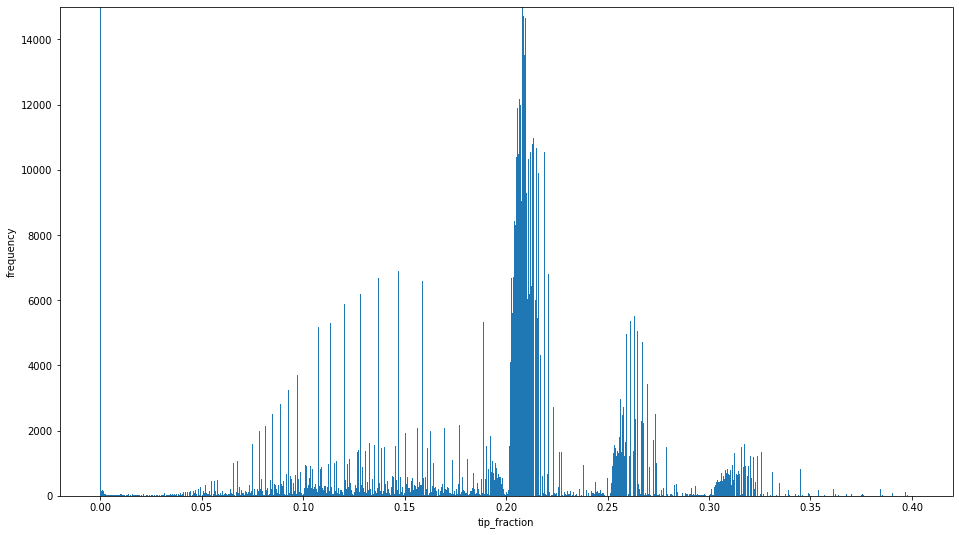

In [15]:
plt.hist(bigdf.tip_fraction, bins=np.linspace(0,0.4,1000))
plt.ylim(0,15000)
plt.ylabel('frequency')
plt.xlabel('tip_fraction')
#plt.savefig('../figs/tip_frac_distribution.png', format='png', dpi=300)
fig = plt.gcf()
fig.set_size_inches(16, 9)
plt.show()

Looks like you have some (at least 5) distinct distributions here.  Please see `figs/tip_frac_distribution.png` for a better look.

* a narrow peak with high intensity just above 20%, the largest feature of the plot
* less than 20%: a normal distribution with mean around 15% superimposed upon
* a broad distribution with a mean near 20% with a low intensity
* a narrow normal distribution > 25% (mean 27%?)
* a narrow normal distriution > 30% (mean 32.5%?)
* big peak at or just over 20%
* peak at or just over 25%
* peak at or just over 30% 
* indicative of different types of riders (sort of obvious, I suppose).

Hopefully none of this is an artifact of sampling.  Would investigate this further, however the above are only observations.

### separate input data into continuous, categorical data

* countinous variables useful for regression
* discrete/label to be one-hot-encoded

* first, split bigdf into two X-dataframes for
    1) labels
    2) continuous vars
* get Y-dataframe (vars to be predicted)

In [16]:
# With intuition + hindsight, we can separate labels from continuous variables.
# Interestingly, zip codes are more numerous than distinct temperature values.

# these will require label and/or one-hot encoding
label_X_vars = ['VendorID', 
                'passenger_count', 
                'RateCodeID', 
                'store_and_fwd_flag', 
                'payment_type', 
                'extra',
                'mta_tax',
                'improvement_surcharge',
                'pickup_zip', 
                'pickup_borough', 
                'pickup_neighborhood', 
                'dropoff_zip', 
                'dropoff_borough', 
                'dropoff_neighborhood', 
                'is_holiday', 
                'Holiday', 
                'Rain', 
                'Fog', 
                'Snow', 
                'weekday', 
                'is_weekend', 
                'pickup_hour',
                'tip_over_twenty_percent'] # to be predicted, not a variable; only for visualization
#                 'tip_fraction']            # continuous predicted variable, not really labeled, only for visualization

# continuous_X_vars = [ col for col in bigdf.columns if col not in label_X_vars ] 

# these may be used in regression models.
continuous_X_vars = [#'pickup_datetime',               # we will use pickup_hour
#                    'dropoff_datetime',               # we will use pickup_hour
                     'trip_distance',
                     'pickup_longitude',
                     'pickup_latitude',
                     'dropoff_longitude',
                     'dropoff_latitude',
                     'fare_amount',
#                      'extra',                        # to labels
#                      'mta_tax',                      # to labels
#                      'tip_amount',
                     'tolls_amount',
#                      'improvement_surcharge',        # to labels
                     'total_amount',                   # <--these two may
                     'user_fare',                      # <--correlate
                     'tip_fraction',                   # to be predicted, not a variable; only for visualization
#                      'tip_over_twenty_percent',     
#                      'pickup_date',                  # deemed irrelevant
#                      'avg_temp_C',                   # use scaled, anomaly
#                      'avg_temp_C_scaled',            # scaled and anomaly have been found to be redundant - ask Allen why
                     'avg_temp_C_anomaly']

# we will predict these
Y_vars = ['tip_fraction', 'tip_over_twenty_percent']


Construct three dataframes (categorial inputs, contionuous inputs, to-be-predicted variables ).

In [17]:

# The Holiday column had some NaN's (Christmas, MLK, NaN if not a holiday)
# Categorical input data
label_X_df = bigdf[label_X_vars]
label_X_df['Holiday'] = label_X_df['Holiday'].fillna('None')

# Continuous input data
continuous_X_df = bigdf[continuous_X_vars]


Y_df = bigdf[Y_vars]

/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Small test to see how many values can be taken by the variables

### Some notable results below:

* There are more zip codes than possible values for temperature, temperature anomaly
* There are more dropoff zips than pickup zips.  Why?
    - imbalance of number of inbound/outbound zip codes?
    - perhaps should consider difference between inbound and outbound passengers

In [18]:
print("#"*80+'''

I realize that the tip_fraction and tip_over_twenty_percent
are variables to be predicted.  They are here for visuialization
purposes for now.  They will obviously not be left in the training
set.

'''+'#'*80)


print('Continuous Variables')
print('variable','num_vals_taken')
for _ in continuous_X_vars:
    print(_,len(set(bigdf[_])))
    
print('\nDiscrete Variables')
print('variable','num_vals_taken')
for _ in label_X_vars:
    print(_,len(set(bigdf[_])))

################################################################################

I realize that the tip_fraction and tip_over_twenty_percent
are variables to be predicted.  They are here for visuialization
purposes for now.  They will obviously not be left in the training
set.

################################################################################
Continuous Variables
variable num_vals_taken
trip_distance 2179
pickup_longitude 18930
pickup_latitude 40651
dropoff_longitude 25919
dropoff_latitude 55852
fare_amount 327
tolls_amount 131
total_amount 4300
user_fare 1474
tip_fraction 10695
avg_temp_C_anomaly 44

Discrete Variables
variable num_vals_taken
VendorID 2
passenger_count 8
RateCodeID 7
store_and_fwd_flag 2
payment_type 4
extra 10
mta_tax 2
improvement_surcharge 2
pickup_zip 163
pickup_borough 5
pickup_neighborhood 40
dropoff_zip 177
dropoff_borough 5
dropoff_neighborhood 42
is_holiday 2
Holiday 15
Rain 2
Fog 2
Snow 2
weekday 7
is_weekend 2
pickup_hour 24
tip_over_twenty_

In [19]:
label_X_df.columns

Index(['VendorID', 'passenger_count', 'RateCodeID', 'store_and_fwd_flag',
       'payment_type', 'extra', 'mta_tax', 'improvement_surcharge',
       'pickup_zip', 'pickup_borough', 'pickup_neighborhood', 'dropoff_zip',
       'dropoff_borough', 'dropoff_neighborhood', 'is_holiday', 'Holiday',
       'Rain', 'Fog', 'Snow', 'weekday', 'is_weekend', 'pickup_hour',
       'tip_over_twenty_percent'],
      dtype='object')

## Determination of correlated continuous variables

We will determine 

    1. correlations between input variables
    2. correlations of the input variables to the predicted variable
Highly correlated input variables threaten the valditiy of a regression model.  We may neglect variables which are correlated.


* I suspect the following may deomstrate correlations

```
fields =   ['fare_amount',
            'tolls_amount',
            'total_amount',
            'user_fare',
            'tip_fraction']

```


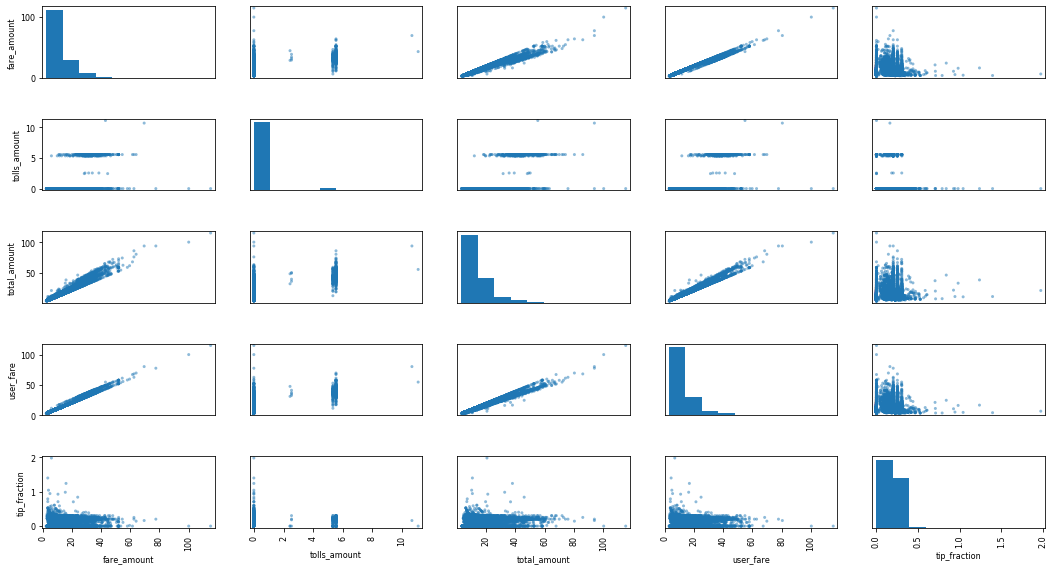

In [284]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

fields =   ['fare_amount',
            'tolls_amount',
            'total_amount',
            'user_fare',
            'tip_fraction']

pd.plotting.scatter_matrix(continuous_X_df[fields].sample(frac=0.01))

plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(16, 9)
#fig.savefig('../figs/continuous_vars_fares.png', format='png', dpi=300)

#### We see that:

1) `user_fare`, `fare_amount`, and `total_amount` are highly correlated.

2) `tip_fraction` depedends categorically on `tolls_amount`.  This is likely due to a few different kinds of trips: e.g., between NY/NJ, inside NY, inside NJ, etc.

3) `tip_fraction` demonstrates complex dependence on the fares.







#### Now let's look at lat-lons with the independent fare and temperature anomaly:

```
fields =   ['trip_distance', 
            'pickup_longitude', 
            'pickup_latitude', 
            'dropoff_longitude', 
            'dropoff_latitude', 
            #'fare_amount', 
            'tolls_amount', 
            #'total_amount', 
            'user_fare', 
            'avg_temp_C_anomaly']

```



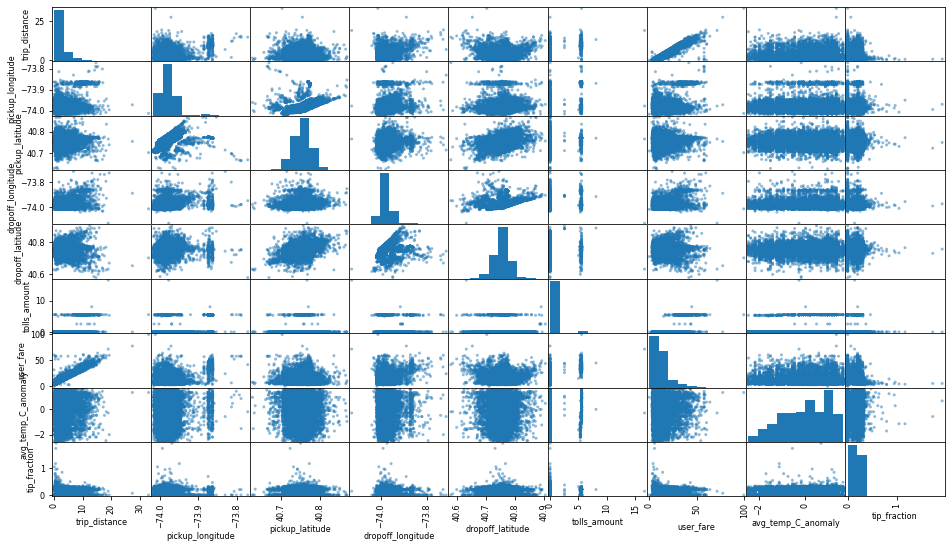

In [285]:
# add in locations (latlons)

fields =   ['trip_distance', 
            'pickup_longitude', 
            'pickup_latitude', 
            'dropoff_longitude', 
            'dropoff_latitude', 
            #'fare_amount', 
            'tolls_amount', 
            #'total_amount', 
            'user_fare', 
            'avg_temp_C_anomaly',
            'tip_fraction']

pd.plotting.scatter_matrix(continuous_X_df[fields].sample(frac=0.01))

fig = plt.gcf()
fig.set_size_inches(16, 9)
#fig.savefig('../figs/continuous_vars_latlons.png', format='png', dpi=300)

#### Now lets try to visualize all correlations among continuous variables + tip_fraction

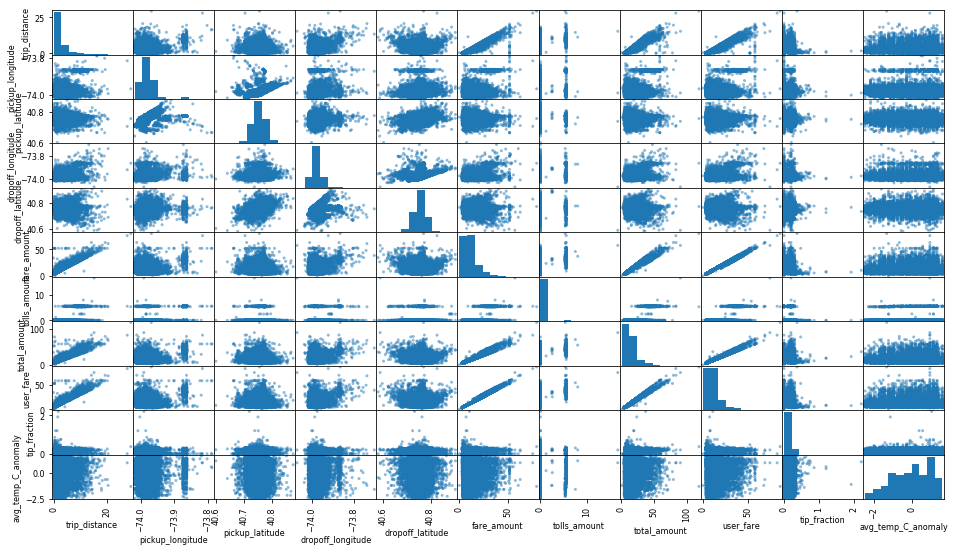

In [286]:
# here try to plot all fields in contonuous_X_df


pd.plotting.scatter_matrix(continuous_X_df.sample(frac=0.01))

fig = plt.gcf()
fig.set_size_inches(16, 9)
#fig.savefig('../figs/continuous_vars_all.png', format='png', dpi=300)

The scattermatrix plots have informed that some input variables (fare related) are so highly correlated they may be removed from a regression model.  There does not seem to be much correlation between geographic params (latlons to fares, tip_fraction).

### Categorical Data

Categorical data must be transformed with label encoders.  We can reatin the encoders in a dictionary to retain the inverse transforms.

In [20]:

label_encoders = OrderedDict()
label_X2_df = pd.DataFrame()


# CREATE TRANSFORMED LABELED DATAFRAME label_X2_df
for col in label_X_df.columns:
    
    le = preprocessing.LabelEncoder()
    
    le.fit(label_X_df[col])
    
    label_encoders[col] = le
    
    label_X2_df[col] = le.transform(label_X_df[col])
    
###############################    
# RETAIN REVERSE TRANSFORMS
# VERY GOOD FUNCTION
###############################
def explain_label_encoder(column, printout=False):
    
    encoder = label_encoders[column]
    
    labeldict = dict()
    for i in range(len(encoder.classes_)):
        labeldict[i] =  encoder.inverse_transform([i])[0]
    if printout:
        for k in labeldict.keys():
            print(k, labeldict[k])
        return
    return labeldict


label_X2_df.head()

# label encoded dataframe

,VendorID,passenger_count,RateCodeID,store_and_fwd_flag,payment_type,extra,mta_tax,improvement_surcharge,pickup_zip,pickup_borough,...,dropoff_neighborhood,is_holiday,Holiday,Rain,Fog,Snow,weekday,is_weekend,pickup_hour,tip_over_twenty_percent
0,1,1,0,0,1,0,1,1,9,2,...,8,0,11,0,0,1,5,0,11,0
1,0,1,0,1,1,0,1,1,39,2,...,39,0,11,0,0,1,5,0,14,0
2,0,1,0,0,1,4,1,1,9,2,...,8,0,11,0,0,1,5,0,17,0
3,0,1,0,0,0,0,1,1,41,2,...,38,0,11,0,0,1,5,0,8,1
4,0,2,0,0,0,0,1,1,41,2,...,39,0,11,0,0,1,5,0,15,0


#### The utility of the explainer function is deonstrated 

In [21]:
explain_label_encoder('Holiday')

{0: 'Christmas Day',
 1: 'Columbus Day',
 2: 'Day after Thanksgiving',
 3: "Father's Day",
 4: 'Independence Day (observed)',
 5: 'Labor Day',
 6: "Lincoln's Birthday",
 7: 'Martin Luther King Jr. Day',
 8: 'Memorial Day',
 9: "Mother's Day",
 10: 'New Years Day',
 11: 'None',
 12: "Presidents' Day",
 13: 'Thanksgiving',
 14: 'Veterans Day'}

In [22]:
explain_label_encoder('weekday')

{0: 'Friday',
 1: 'Monday',
 2: 'Saturday',
 3: 'Sunday',
 4: 'Thursday',
 5: 'Tuesday',
 6: 'Wednesday'}

In [23]:
explain_label_encoder('dropoff_neighborhood')

{0: 'Borough Park',
 1: 'Bronx Park and Fordham',
 2: 'Bushwick and Williamsburg',
 3: 'Canarsie and Flatlands',
 4: 'Central Bronx',
 5: 'Central Brooklyn',
 6: 'Central Harlem',
 7: 'Central Queens',
 8: 'Chelsea and Clinton',
 9: 'East Harlem',
 10: 'East New York and New Lots',
 11: 'Flatbush',
 12: 'Gramercy Park and Murray Hill',
 13: 'Greenpoint',
 14: 'Greenwich Village and Soho',
 15: 'High Bridge and Morrisania',
 16: 'Hunts Point and Mott Haven',
 17: 'Inwood and Washington Heights',
 18: 'Jamaica',
 19: 'Kingsbridge and Riverdale',
 20: 'Lower East Side',
 21: 'Lower Manhattan',
 22: 'Mid-Island',
 23: 'North Queens',
 24: 'Northeast Bronx',
 25: 'Northeast Queens',
 26: 'Northwest Brooklyn',
 27: 'Northwest Queens',
 28: 'Port Richmond',
 29: 'Rockaways',
 30: 'South Shore',
 31: 'Southeast Bronx',
 32: 'Southeast Queens',
 33: 'Southern Brooklyn',
 34: 'Southwest Brooklyn',
 35: 'Southwest Queens',
 36: 'Stapleton and St. George',
 37: 'Sunset Park',
 38: 'Upper East Side

## Visualize categorical data

Kinda tricky

Create cheapy histograms using scattermatrix to eye-ball the affect of the following on tips

1. boroughs
2. holidays
3. weather and day of the week 

## Concolusions regarding categorical variables

    1. Tips tend higher for borough 2 (Manhattan)
    2. Tips fall off as number of passengers increases - bystander effect? (not my job to tip!)
    3. Thanksgiving tips and Independence Day tips can be higher than normal (not christmas!).  The "No-holiday" still has the most large tips.
    4. The biggest tips occur on Sunday and Friday
    5. Vendor 1 has some higher tips (uber or lyft, data doesnt say).
    
Use the plots by looking at the variable v.s. `tip_fraction`

################################################################################
Pay Attention to the right most column of the following
plots; it represents the relationship of the categorical 
variables to the continuous tip_fraction.

Beaneath the plot are the decoded categorical names -
e.g. 2 is Manhattan, 3 is Sunday, 13 is Thanksgiving.
################################################################################




/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


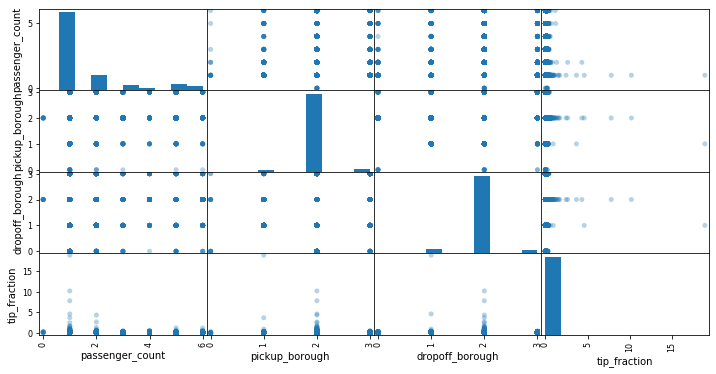

0 Bronx
1 Brooklyn
2 Manhattan
3 Queens
4 Staten Island


/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


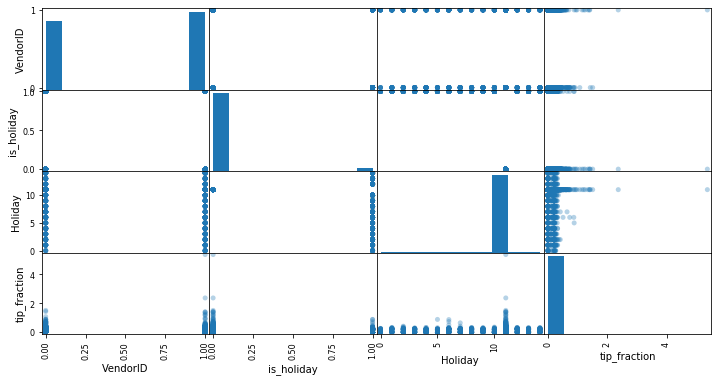

0 Christmas Day
1 Columbus Day
2 Day after Thanksgiving
3 Father's Day
4 Independence Day (observed)
5 Labor Day
6 Lincoln's Birthday
7 Martin Luther King Jr. Day
8 Memorial Day
9 Mother's Day
10 New Years Day
11 None
12 Presidents' Day
13 Thanksgiving
14 Veterans Day


/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


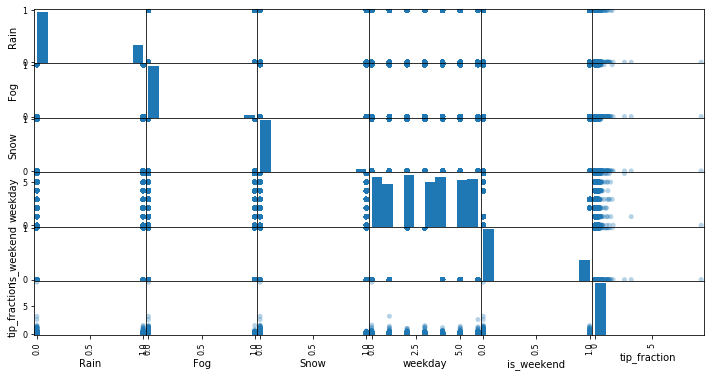

0 Friday
1 Monday
2 Saturday
3 Sunday
4 Thursday
5 Tuesday
6 Wednesday


In [24]:
ALPHA=0.33
SIZE=25

print('#'*80+'''
Pay Attention to the right most column of the following
plots; it represents the relationship of the categorical 
variables to the continuous tip_fraction.

Beaneath the plot are the decoded categorical names -
e.g. 2 is Manhattan, 3 is Sunday, 13 is Thanksgiving.
'''+'#'*80+'\n\n')

# plot 1 - boroughs
fields = [#'VendorID',
 'passenger_count',
# 'RateCodeID',
# 'store_and_fwd_flag',
# 'payment_type',
# 'extra',
# 'mta_tax',
# 'improvement_surcharge',
# 'pickup_zip',
 'pickup_borough',
# 'pickup_neighborhood',
# 'dropoff_zip',
 'dropoff_borough']
# 'dropoff_neighborhood',
#  'is_holiday',
#  'Holiday',
#  'Rain',
#  'Fog',
#  'Snow',
#  'weekday',
#   'is_weekend',
# 'pickup_hour',
# 'tip_fraction']

# Lets add in the contionuous variable tip_fraction to see if we can see some density differences amongst boroughs, etc

test_label_df = label_X2_df[fields]
test_label_df['tip_fraction'] = bigdf['tip_fraction']
pd.plotting.scatter_matrix(test_label_df.sample(frac=0.02), marker='o', alpha=ALPHA, s=SIZE)
fig = plt.gcf()
fig.set_size_inches(12, 6)
# fig.savefig('../figs/label_vars_boroughs.png', format='png', dpi=300)
plt.show()
explain_label_encoder('dropoff_borough', printout=1)



# plot 2 - holidays
fields = ['VendorID',
         'is_holiday',
         'Holiday']

test_label_df = label_X2_df[fields]
test_label_df['tip_fraction'] = bigdf['tip_fraction']
pd.plotting.scatter_matrix(test_label_df.sample(frac=0.02), marker='o', alpha=ALPHA, s=SIZE)
fig = plt.gcf()
fig.set_size_inches(12, 6)
# fig.savefig('../figs/label_vars_holidays.png', format='png', dpi=300)
plt.show()
explain_label_encoder('Holiday', printout=1)

# plot 3 - days/weather
fields = [
 'Rain',
 'Fog',
 'Snow',
 'weekday',
  'is_weekend']

# Lets add in the contionuous variable tip_fraction to see if we can see some density differences amongst boroughs, etc

test_label_df = label_X2_df[fields]
test_label_df['tip_fraction'] = bigdf['tip_fraction']
pd.plotting.scatter_matrix(test_label_df.sample(frac=0.02), marker='o', alpha=ALPHA, s=SIZE)
fig = plt.gcf()
fig.set_size_inches(12, 6)
# fig.savefig('../figs/label_vars_day_weather.png', format='png', dpi=300)
plt.show()
explain_label_encoder('weekday', printout=1)

# 3.   Models

# 3.a) Regression Models


I see that this problem could be solved using continious or categorical classification. 

I dont really know which models will work best, so I will try several. 

* I do not expect regression to be successfull due to the multi-modal nature of the tip distribution, but let us try anyhow first a simple LinearRegression to predict the continuous variable `tip_fraction` (...for science).

* Let us choose a training set of 75% of the dataset and predict on 25%.  These are magic numbers and can be changed later. 

* Lets not forget that the training data is chronological, and should be scrambled before it is partitioned into X_TRAIN, X_PREDICT ...






In [292]:
continuous_X_df.head(10)

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tolls_amount,total_amount,user_fare,tip_fraction,avg_temp_C_anomaly
0,1.78,-73.999619,40.743599,-73.992203,40.764019,9.0,0.0,9.80,9.3,0.000000,-1.890643
1,1.80,-73.968254,40.767300,-73.967339,40.788025,9.0,0.0,9.80,9.3,0.000000,-1.890643
2,0.90,-73.998901,40.745388,-73.990288,40.751408,7.0,0.0,8.80,8.3,0.000000,-1.890643
3,0.70,-73.945030,40.779266,-73.951805,40.769947,7.5,0.0,9.95,7.8,0.211538,-1.890643
4,2.90,-73.955978,40.787697,-73.983749,40.774132,16.0,0.0,18.55,16.3,0.107362,-1.890643
5,1.45,-73.952667,40.783474,-73.966713,40.766895,7.0,0.0,8.30,7.8,0.000000,-1.890643
6,2.30,-73.998856,40.738396,-74.010849,40.720112,11.0,0.0,12.80,12.3,0.000000,-1.890643
7,1.30,-73.973396,40.763760,-73.987579,40.750698,7.0,0.0,8.80,8.3,0.000000,-1.890643
8,3.00,-74.015854,40.714928,-74.008507,40.746574,14.0,0.0,15.80,15.3,0.000000,-1.890643
9,1.40,-73.954025,40.784470,-73.972389,40.782326,9.5,0.0,10.30,9.8,0.000000,-1.890643


In [293]:
# this should scramble it up
continuous_X_df = continuous_X_df.sample(frac=1)
continuous_X_df.head(10)

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tolls_amount,total_amount,user_fare,tip_fraction,avg_temp_C_anomaly
1190085,11.10,-74.002937,40.728195,-73.870857,40.774029,35.0,5.54,42.34,41.84,0.000000,-0.088855
410394,2.50,-73.978577,40.783253,-73.979904,40.755630,10.5,0.00,14.75,11.30,0.261062,0.954285
1089673,1.93,-73.961609,40.768429,-73.985229,40.760651,13.5,0.00,17.16,13.80,0.207246,-0.183686
178065,1.22,-73.983833,40.746948,-73.972572,40.757324,7.5,0.00,8.30,7.80,0.000000,-2.080305
1149947,0.67,-74.014381,40.713928,-74.016754,40.706406,4.5,0.00,5.30,4.80,0.000000,-0.942334
32614,0.90,-73.982056,40.781372,-73.990791,40.770168,6.0,0.00,8.50,6.30,0.269841,-0.942334
679290,0.87,-74.006210,40.743851,-73.995232,40.743851,5.0,0.00,6.30,5.80,0.000000,1.143947
527135,2.61,-74.002731,40.749828,-73.984612,40.727291,11.5,0.00,16.00,12.30,0.260163,1.238778
991200,0.96,-73.964951,40.796478,-73.973663,40.784599,6.5,0.00,7.30,6.80,0.000000,0.669792
113097,9.12,-73.885948,40.773026,-73.975677,40.781834,30.0,5.33,46.21,36.63,0.247884,-1.226826


#### I am going to min-max scale all of it (except tip_fraction --- thats what we want to predict and I dont want to bother with transforming it back.

In [294]:
TIP_FRAC_Y = continuous_X_df['tip_fraction']
continuous_X_df = continuous_X_df.drop(columns=['tip_fraction'])

print(continuous_X_df.columns)



Index(['trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'tolls_amount',
       'total_amount', 'user_fare', 'avg_temp_C_anomaly'],
      dtype='object')


In [295]:
continuous_X_df_scaled = continuous_X_df.apply(get_min_max)

continuous_X_df_scaled.head(10)

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tolls_amount,total_amount,user_fare,avg_temp_C_anomaly
1190085,9.406779e-07,0.272782,0.458340,0.681356,0.653204,0.043738,0.040998,0.052538,0.051913,0.581395
410394,2.118644e-07,0.332553,0.625201,0.479289,0.606891,0.013113,0.000000,0.018050,0.013738,0.837209
1089673,1.635593e-07,0.374186,0.580274,0.469421,0.619528,0.016863,0.000000,0.021063,0.016863,0.558140
178065,1.033898e-07,0.319656,0.515174,0.492875,0.611154,0.009363,0.000000,0.009988,0.009363,0.093023
1149947,5.677966e-08,0.244702,0.415101,0.411005,0.482979,0.005613,0.000000,0.006238,0.005613,0.372093
32614,7.627118e-08,0.324017,0.619501,0.459114,0.643486,0.007488,0.000000,0.010238,0.007488,0.372093
679290,7.372881e-08,0.264751,0.505786,0.450886,0.577238,0.006238,0.000000,0.007488,0.006863,0.883721
527135,2.211864e-07,0.273287,0.523903,0.470566,0.535553,0.014363,0.000000,0.019613,0.014988,0.906977
991200,8.135593e-08,0.365987,0.665283,0.490853,0.679813,0.008113,0.000000,0.008738,0.008113,0.767442
113097,7.728813e-07,0.559828,0.594206,0.487121,0.672851,0.037488,0.039443,0.057376,0.045401,0.302326


# PARTITION INTO TRAIN, PREDICT

In [296]:
print(len(continuous_X_df_scaled))
print(len(continuous_X_df_scaled)//4*3)
print(len(continuous_X_df_scaled)//4)

headpart = len(continuous_X_df_scaled)//4*3
tailpart = len(continuous_X_df_scaled)//4

X_TRAIN_df   = continuous_X_df_scaled.head(headpart)
X_PREDICT_df = continuous_X_df_scaled.tail(tailpart)

Y_TRAIN_df   = TIP_FRAC_Y.head(headpart)
Y_PREDICT_df = TIP_FRAC_Y.tail(tailpart)

1200000
900000
300000


In [298]:
def make_df_a_featureset(df, feature_cols=None):
    
    if feature_cols is None:
        
        return np.array([ np.array(list((x))) for x in df.to_numpy() ])
    
    else:
        
        df2 = df[feature_cols]
        
        return np.array([ np.array(list((x))) for x in df2.to_numpy() ])
        

REMEMBER: `Y_PREDICT` is really more like "Y_ACTUAL".

In [299]:
X_TRAIN    = make_df_a_featureset(X_TRAIN_df)
Y_TRAIN    = np.array(Y_TRAIN_df)

X_PREDICT  = make_df_a_featureset(X_PREDICT_df)
Y_PREDICT  = np.array(Y_PREDICT_df)



array([-1.92478432e+03, -4.75370180e-02, -8.80532676e-03,  4.90739073e-03,
       -4.24876000e-03,  3.16900623e-01, -7.31769861e-01,  5.11041027e+01,
       -5.73825532e+01, -1.24089143e-04])

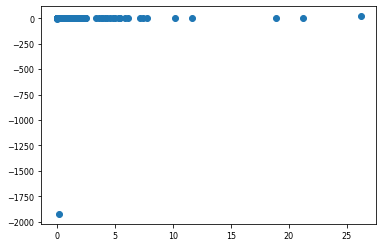

In [300]:
# models = [RidgeCV, LinearRegression, LassoCV, LogisticRegressionCV]

model = LinearRegression()
model.fit(X_TRAIN,Y_TRAIN)
y_predicted = model.predict(X_PREDICT)
plt.scatter(Y_PREDICT,y_predicted)
model.coef_



In [301]:
def get_avg_error(predicted, should_be):
    
    diffs = []
    
    for idx, predicted_value in enumerate(predicted):
        
        diff = abs(should_be[idx] - predicted_value)
        
        diffs.append(diff)
        
    return np.average(diffs)

avg_err = get_avg_error(Y_PREDICT,y_predicted)

print('MODEL IS LinearRegression')
print(f'AVG ERROR IS {avg_err}')
print(model.score(X_PREDICT, Y_PREDICT))

MODEL IS LinearRegression
AVG ERROR IS 0.05358466999346523
-611.8829684476418



################################################################################
MODEL IS RidgeCV
################################################################################


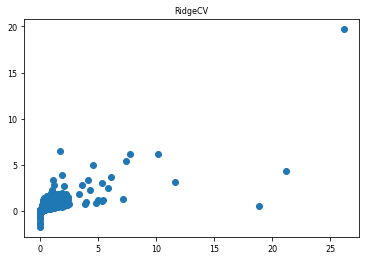

coefs [-1.81463798e-03 -4.65688652e-02 -5.76546581e-03 -7.28845512e-03
 -2.51086053e-03 -1.39364903e+01 -3.05430893e+00  4.88136325e+01
 -4.05834053e+01 -5.44952270e-04]
AVG ERROR IS 0.04819464088689165
0.6389409271476697


################################################################################
MODEL IS LinearRegression
################################################################################


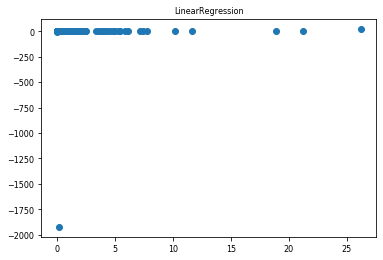

coefs [-1.92478432e+03 -4.75370180e-02 -8.80532676e-03  4.90739073e-03
 -4.24876000e-03  3.16900623e-01 -7.31769861e-01  5.11041027e+01
 -5.73825532e+01 -1.24089143e-04]
AVG ERROR IS 0.05358466999346523
-611.8829684476418


################################################################################
MODEL IS LassoCV
################################################################################


/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


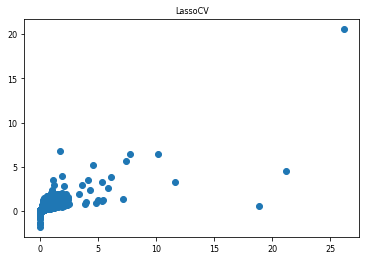

coefs [-0.00000000e+00 -4.79627905e-02 -8.54945076e-03  3.06229219e-03
 -3.87144408e-03 -0.00000000e+00 -7.71085248e-01  5.09211435e+01
 -5.68951334e+01 -1.30327820e-04]
AVG ERROR IS 0.0472202649216119
0.6430486436079283


################################################################################
MODEL IS LinearSVR
################################################################################


/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


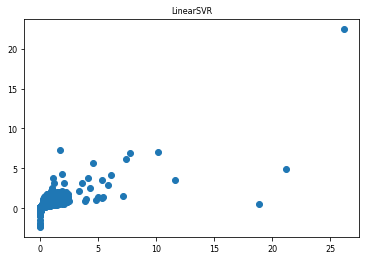

coefs [-5.71944006e-04 -4.36609433e-02  2.06007198e-03 -1.79072966e-02
 -1.60623915e-03 -1.10717790e+01 -3.46155389e+00  5.56091703e+01
 -5.23103596e+01 -2.28871551e-04]
AVG ERROR IS 0.04600651197008874
0.6254616762117973



In [302]:
Models      = [RidgeCV(), LinearRegression(), LassoCV(), LinearSVR()]
Model_names = ['RidgeCV','LinearRegression','LassoCV', 'LinearSVR']

for idx, model_ in enumerate(Models):
    print()
    name  = Model_names[idx]
    print('#'*80)
    print(f'MODEL IS {name}')
    print('#'*80)
    
    model = model_
    model.fit(X_TRAIN,Y_TRAIN)
    y_predicted = model.predict(X_PREDICT)
    plt.scatter(Y_PREDICT,y_predicted)
    plt.title(name)
    plt.show()
    print('coefs',model.coef_)
    avg_err = get_avg_error(Y_PREDICT,y_predicted)

    
    print(f'AVG ERROR IS {avg_err}')
    print(model.score(X_PREDICT, Y_PREDICT))
    print()
    


# Regression Conclusions:

* Lasso regression threw out trip_distance and fare_amount as inconsequential.

* The accuracy is poor across the board

* These models are not expected to perform well on such a strange distribution.

* Did not even consider weekday, is_holiday etc.  These catagorical varibles could still function in a regression model. Would require one-hot encoding.


# LOGISTIC REGRESSION PREDICTING DISCRETE tip_over_twenty_percent

We just have to swap out the Y_PREDICTED with the discrete `tip_over_twenty_percent`

Unfortunately, I scrmbled the continuous data and did not scramble the `tip_over_twenty_percent` variable in the same ordering.   Gotta fix that.

The variable `tip_over_twenty_percent` is hanging out in the dataframe `label_X_df`

In [303]:
label_X_df.columns

Index(['VendorID', 'passenger_count', 'RateCodeID', 'store_and_fwd_flag',
       'payment_type', 'extra', 'mta_tax', 'improvement_surcharge',
       'pickup_zip', 'pickup_borough', 'pickup_neighborhood', 'dropoff_zip',
       'dropoff_borough', 'dropoff_neighborhood', 'is_holiday', 'Holiday',
       'Rain', 'Fog', 'Snow', 'weekday', 'is_weekend', 'pickup_hour',
       'tip_over_twenty_percent'],
      dtype='object')

#### I should avoid this for loop, but im getting tired. Sorry.

In [304]:
scrambled_tip_over_twenty_percent = []
i=0
for idx in continuous_X_df_scaled.index:
    
    scrambled_tip_over_twenty_percent.append(label_X_df.iloc[idx].tip_over_twenty_percent)
    
    
    
    i+=1
    
    if i%10000==0:
        sys.stdout.write(f'\r{i} out of {1200000}')

scrambled_tip_over_twenty_percent = np.array(scrambled_tip_over_twenty_percent)

1200000 out of 1200000

In [305]:
Y_TRAIN_BOOL   = scrambled_tip_over_twenty_percent[:headpart]
Y_PREDICT_BOOL = scrambled_tip_over_twenty_percent[-tailpart:]

print(len(Y_TRAIN_BOOL), len(Y_PREDICT_BOOL))

900000 300000


#### Need to check that this routine below makes sense for logistic regression on a boolean 

This is not the right way



################################################################################
MODEL IS LogisticRegressionCV
################################################################################


/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/linea

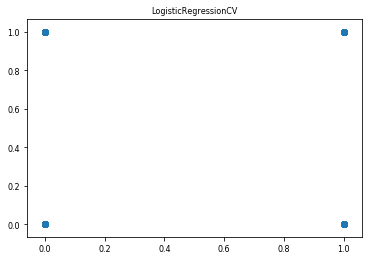

coefs [[-8.91429062e-02 -1.91045728e+00  4.85632064e-01 -1.73995199e+00
   2.91251372e-01 -1.39405315e+03 -1.61346476e+02  4.33038285e+03
  -3.77168082e+03  8.87426535e-01]]
AVG ERROR IS 0.03632666666666667



In [310]:
Models      = [LogisticRegressionCV()]
Model_names = ['LogisticRegressionCV']

for idx, model_ in enumerate(Models):
    print()
    print('#'*80)
    name  = Model_names[idx]
    print(f'MODEL IS {name}')
    print('#'*80)
    
    model = model_
    model.fit(X_TRAIN,Y_TRAIN_BOOL)
    y_predicted_bool = model.predict(X_PREDICT)
    plt.scatter(Y_PREDICT_BOOL,y_predicted_bool)
    plt.title(name)
    plt.show()
    print('coefs',model.coef_)
    avg_err = get_avg_error(Y_PREDICT_BOOL,y_predicted_bool)

    
    print(f'AVG ERROR IS {avg_err}')
   # print(model.score(X_PREDICT, Y_PREDICT))
    print()
    

### That plot is not terrribly illuminating, but how about ... leta just count how many below turn out to be true?

In [314]:


NUM_CORRECT = len([ x for x in Y_PREDICT_BOOL == y_predicted_bool if x ])
OUT_OF = len(y_predicted_bool)

print('#'*80)
print('Results of LogisticRegressionCV')
print(f'Num Correct: {NUM_CORRECT} out of {OUT_OF}')
print('ACCURACY:', NUM_CORRECT/OUT_OF)
print('not to shabby')
print('#'*80)

################################################################################
Results of LogisticRegressionCV
Num Correct: 289102 out of 300000
ACCURACY: 0.9636733333333334
not to shabby
################################################################################


This result seems too good to be true.  Perhaps most of the tips are below 20%, and the best predictor would be to guess that no tips are above 20%.  Let us verify ...

In [317]:
print(len([x for x in bigdf.tip_fraction if x>0.2 ]))
print(len(bigdf))
frac = len([x for x in bigdf.tip_fraction if x>0.2 ])/len(bigdf)
print(f'fraction of tips that are over 20% is {frac}')

print('So, an estimator that always answers in the negative would not do better than the above LogisticRegression.')
print("I am not sure why that accuracy is so high. I'm skeptical")

512545
1200000
fraction of tips that are over 20% is 0.42712083333333334
So, an estimator that always answers in the negative would not do better than the above LogisticRegression.
I am not sure why that accuracy is so high. I'm skeptical


# Hyperparameter tuning

* I would put this off for now because I do not think regression will do well for this dataset. 

* That said, once can iterate through the params to see if there if improvement, particularly for the case of the SVR, which is often a fruitful endeavor.

# 3b) Classification Models

In [25]:
# we will use this one

label_X2_df

,VendorID,passenger_count,RateCodeID,store_and_fwd_flag,payment_type,extra,mta_tax,improvement_surcharge,pickup_zip,pickup_borough,...,dropoff_neighborhood,is_holiday,Holiday,Rain,Fog,Snow,weekday,is_weekend,pickup_hour,tip_over_twenty_percent
0,1,1,0,0,1,0,1,1,9,2,...,8,0,11,0,0,1,5,0,11,0
1,0,1,0,1,1,0,1,1,39,2,...,39,0,11,0,0,1,5,0,14,0
2,0,1,0,0,1,4,1,1,9,2,...,8,0,11,0,0,1,5,0,17,0
3,0,1,0,0,0,0,1,1,41,2,...,38,0,11,0,0,1,5,0,8,1
4,0,2,0,0,0,0,1,1,41,2,...,39,0,11,0,0,1,5,0,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1,6,0,0,0,3,1,1,20,2,...,8,1,0,1,0,0,0,0,23,1
1199996,1,1,0,0,0,0,1,1,18,2,...,8,1,0,1,0,0,0,0,9,1
1199997,0,1,0,0,0,0,1,1,129,3,...,39,1,0,1,0,0,0,0,14,1
1199998,1,1,0,0,0,0,1,1,20,2,...,8,1,0,1,0,0,0,0,16,1


In [26]:
label_X2_df = label_X2_df.sample(frac=1)

Y_BOOL = label_X2_df['tip_over_twenty_percent']

label_X3_df = label_X2_df.drop(columns=['tip_over_twenty_percent'])

print(label_X3_df.columns)

Index(['VendorID', 'passenger_count', 'RateCodeID', 'store_and_fwd_flag',
       'payment_type', 'extra', 'mta_tax', 'improvement_surcharge',
       'pickup_zip', 'pickup_borough', 'pickup_neighborhood', 'dropoff_zip',
       'dropoff_borough', 'dropoff_neighborhood', 'is_holiday', 'Holiday',
       'Rain', 'Fog', 'Snow', 'weekday', 'is_weekend', 'pickup_hour'],
      dtype='object')


# PARTITION TRAIN, PREDICT

75/25 split

In [27]:
print(len(label_X3_df))
print(len(label_X3_df)//4*3)
print(len(label_X3_df)//4)

headpart = len(label_X3_df)//4*3
tailpart = len(label_X3_df)//4

X_TRAIN_df   = label_X3_df.head(headpart)
X_PREDICT_df = label_X3_df.tail(tailpart)

Y_TRAIN_df   = Y_BOOL.head(headpart)
Y_PREDICT_df = Y_BOOL.tail(tailpart)

1200000
900000
300000


In [28]:
def make_df_a_featureset(df, feature_cols=None):
    
    if feature_cols is None:
        
        return np.array([ np.array(list((x))) for x in df.to_numpy() ])
    
    else:
        
        df2 = df[feature_cols]
        
        return np.array([ np.array(list((x))) for x in df2.to_numpy() ])

In [29]:
X_TRAIN    = make_df_a_featureset(X_TRAIN_df)
Y_TRAIN    = np.array(Y_TRAIN_df)

X_PREDICT  = make_df_a_featureset(X_PREDICT_df)
Y_PREDICT  = np.array(Y_PREDICT_df)




# Start with good old naive bayes

In [30]:
model = GaussianNB()

In [31]:
model.fit(X_TRAIN,Y_TRAIN)
y_predicted = model.predict(X_PREDICT)



In [32]:
model.score(X_PREDICT,Y_PREDICT)

0.79372

Ok, well lets try other classifiers and see what performs well.

In [ ]:
Models = [ #LinearSVC(), 
          GaussianNB(), 
          DecisionTreeClassifier(), 
          RandomForestClassifier(), 
          AdaBoostClassifier(), 
          #SVC(), 
          KNeighborsClassifier()]#,
          #MLPClassifier() ]

Model_names = [ #'LinearSVC()', 
          'GaussianNB()', 
          'DecisionTreeClassifier()', 
          'RandomForestClassifier()', 
          'AdaBoostClassifier()', 
          #'SVC()', 
          'KNeighborsClassifier()']#,
          #'MLPClassifier()' ]

for idx, model_ in enumerate(Models):
    print()
    print('#'*80)
    name  = Model_names[idx]
    print(f'MODEL IS {name}')
    
    
    model = model_
    model.fit(X_TRAIN,Y_TRAIN)
    y_predicted = model.predict(X_PREDICT)
    score = model.score(X_PREDICT,Y_PREDICT)
    print(f'Score is {score}')
    print('#'*80)
    print()
    


################################################################################
MODEL IS GaussianNB()
Score is 0.79372
################################################################################


################################################################################
MODEL IS DecisionTreeClassifier()
Score is 0.7237233333333334
################################################################################


################################################################################
MODEL IS RandomForestClassifier()


/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score is 0.7465466666666667
################################################################################


################################################################################
MODEL IS AdaBoostClassifier()
Score is 0.79781
################################################################################


################################################################################
MODEL IS SVC()


/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### This would be much better if I one-hot encoded all the holidays and the weekdays.
